More Haar Features in OpenCV - https://github.com/opencv/opencv/tree/master/data/haarcascades

### Code

#### Image 

In [1]:
import cv2
import matplotlib.pyplot as plt

def detectHC(imgpath):
    cascPath = "./haarcascades/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascPath)


    font = cv2.FONT_HERSHEY_SIMPLEX

    frame = cv2.imread(imgpath)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(200, 200),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 3)
        cv2.putText(frame,'Face',(x, y), font, 2,(255,0,0),5)

    cv2.putText(frame,'Number of Faces : ' + str(len(faces)),(40, 40), font, 1,(255,0,0),3)
    plt.imshow(frame)
    plt.show()


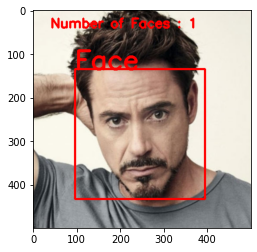

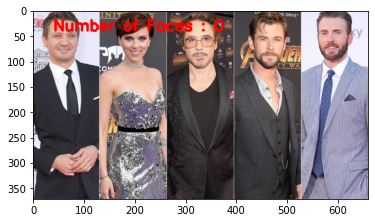

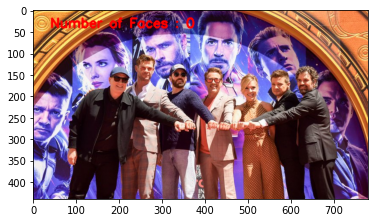

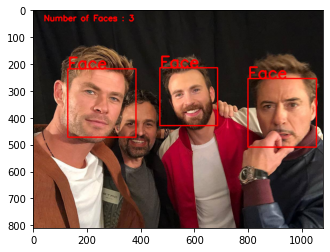

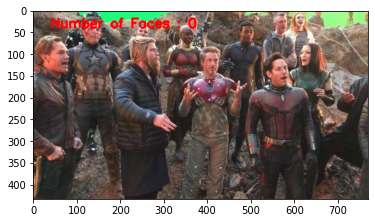

In [2]:
detectHC('./data/tony.jpg')
detectHC('./data/group.jpg')
detectHC('./data/groupsmall.jpg')
detectHC('./data/groupbig.jpg')
detectHC('./data/groupangle.jpeg')


#### Video 

In [9]:
import cv2

def detectVidHC(vidPath):
    cascPath = "./haarcascades/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascPath)
    font = cv2.FONT_HERSHEY_SIMPLEX
    video_capture = cv2.VideoCapture(vidPath)
    
    
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')


    while True:
        # Capture frame-by-frame
        ret, frame = video_capture.read()

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(200, 200),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        # Draw a rectangle around the faces
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 3)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = frame[y:y+h, x:x+w]
            cv2.putText(frame,'Face',(x, y), font, 2,(255,0,0),5)

        cv2.putText(frame,'Number of Faces : ' + str(len(faces)),(40, 40), font, 1,(255,0,0),2)      
        # Display the resulting frame

        cv2.imshow('Video', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break

    # When everything is done, release the capture
    video_capture.release()
    cv2.destroyAllWindows()

In [10]:
detectVidHC('./data/videoplayback.mp4')

#### Real-Time

In [5]:
import cv2


cascPath = "./haarcascades/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

font = cv2.FONT_HERSHEY_SIMPLEX
video_capture = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(200, 200),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 3)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.putText(frame,'Face',(x, y), font, 2,(255,0,0),5)

    cv2.putText(frame,'Number of Faces : ' + str(len(faces)),(40, 40), font, 1,(255,0,0),2)      
    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

### Pros
1. Works almost real-time on CPU
2. Simple Architecture
3. Detects faces at different scales

### Cons
1. The major drawback of this method is that it gives a lot of False predictions.
2. Doesn’t work on non-frontal images.
3. Doesn’t work under occlusion

## 3. Histogram of Oriented Gradients (HOG) in Dlib

One of the most popular implement for face detection is offered by Dlib and uses a concept called Histogram of Oriented Gradients (HOG). This is an implementation of the original paper by Dalal and Triggs - https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf

The model is built out of 5 HOG filters – front looking, left looking, right looking, front looking but rotated left, and a front looking but rotated right. The model comes embedded in the header(https://github.com/davisking/dlib/blob/master/dlib/image_processing/frontal_face_detector.h) file itself.

The dataset used for training, consists of 2825 images which are obtained from LFW dataset and manually annotated by Davis King, the author of Dlib. It can be downloaded from here - http://vis-www.cs.umass.edu/lfw/.

The idea behind HOG is to extract features into a vector, and feed it into a classification algorithm like a Support Vector Machine for example that will assess whether a face (or any object you train it to recognize actually) is present in a region or not.

The features extracted are the distribution (histograms) of directions of gradients (oriented gradients) of the image. Gradients are typically large around edges and corners and allow us to detect those regions.

In the original paper, the process was implemented for human body detection, and the detection chain was the following :

<img src="./file/hog.png">


#### Computing the gradient images
The first step is to compute the horizontal and vertical gradients of the image, by applying the following kernels :

<img src="./file/gradient.PNG">

The gradient of an image typically removes non-essential information.

#### Compute tyhe HOG

The image is then divided into 8x8 cells to offer a compact representation and make our HOG more robust to noise. Then, we compute a HOG for each of those cells.

To estimate the direction of a gradient inside a region, we simply build a histogram among the 64 values of the gradient directions (8x8) and their magnitude (another 64 values) inside each region. The categories of the histogram correspond to angles of the gradient, from 0 to 180°. Ther are 9 categories overall : 0°, 20°, 40°… 160°.

We then calculate 2 information :
1. Direction of the gradient
2. Magnitude of the gradient

When we build the HOG, there are 3 subcases :
1. The angle is smaller than 160° and not halfway between 2 classes. In such case, the angle will be added in the right category of the HOG
2. The angle is smaller than 160° and exactly between 2 classes. In such case, we consider an equal contribution to the 2 nearest classes and split the magnitude in 2
<img src="./file/hog1.png">

3. the angle is larger than 160°. In such case, we consider that the pixel contributed proportionally to 160° and to 0°.
<img src="./file/hog2.png">

The HOG looks like this for each 8x8 cell :
<img src="./file/hog3.png">

#### Block normalization
Finally, a 16x16 block can be applied in order to normalize the image and make it invariant to lighting for example. This is simply achieved by dividing each value of the HOG of size 8x8 by the L2-norm of the HOG of the 16x16 block that contains it, which is in fact a simple vector of length 9*4 = 36.

Finally, all the 36x1 vectors are concatenated into a large vector. And we are done ! We have our feature vector, on which we can train a soft SVM classifier.
![SegmentLocal](file/hog.gif "segment")

  


#### Code

#### Image

In [14]:

import cv2
import dlib
from imutils import face_utils
import matplotlib.pyplot as plt
def detectDlib(imgpath):
    frame = cv2.imread(imgpath)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_detect = dlib.get_frontal_face_detector()
    rects = face_detect(gray, 1)
    for (i, rect) in enumerate(rects):
        (x, y, w, h) = face_utils.rect_to_bb(rect)

        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 3)
    plt.imshow(frame)
    plt.show()

ModuleNotFoundError: No module named 'imutils'

In [ ]:
import cv2
import dlib

In [ ]:
detectDlib('./data/tony.jpg')
detectDlib('./data/group.jpg')
detectDlib('./data/groupsmall.jpg')
detectDlib('./data/groupbig.jpg')
detectDlib('./data/groupangle.jpeg')


#### Video

In [ ]:
import cv2
import dlib
from imutils import face_utils
def detectVidHOG(vidpath):
    video_capture = cv2.VideoCapture(vidpath)
    flag = 0

    #fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    #out = cv2.VideoWriter('outputHOG.avi',fourcc,20.0,(int(video_capture.get(3)),int(video_capture.get(4))))
    while True:

        ret, frame = video_capture.read()
        #frame = cv2.resize(frame,(256,256))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        face_detect = dlib.get_frontal_face_detector()

        rects = face_detect(gray, 1)
        
        for (i, rect) in enumerate(rects):

            (x, y, w, h) = face_utils.rect_to_bb(rect)

            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 2)
        #out.write(frame)
        cv2.imshow('Video', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video_capture.release()
    cv2.destroyAllWindows()

In [ ]:
detectVidHOG('./data/videoplayback.mp4')

#### Real Time

In [ ]:
import cv2
import dlib
from imutils import face_utils

video_capture = cv2.VideoCapture(0)
flag = 0

while True:

    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = face_detect(gray, 1)

    for (i, rect) in enumerate(rects):

        (x, y, w, h) = face_utils.rect_to_bb(rect)

        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 2)

        cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()